# Monsters and Mixtures

We'll consider three common and useful examples. The first are models for handling OVER_DISPERSION. These models extend the binomial and Poisson models to cope a bit with unmeasured sources of variation.

The second type is a family of ZERO-INFLATED and ZERO-AUGMENTED models, each of which mixes a binary event with an ordinary GLM liklihood like a Poisson or binomial.

The third type is the ORDERED CATEGORICAL model. Useful for categorical outcomes with a fixed ordering.

These models help us transform out modelling to cope with the inconvienient realities of meansurement, rather than transforming measurements to cope with the constraints of our models.

## Over dispersed counts

In an earlier chapter, I argued that models based on normal distributions can be overly sensitive to extreme observations. The problem isn't that necessary 'outliers' are bad data. Rather processes are often variable mixtures and this results in thicker tails. Models that assume a thin tail, like a pure gaussian model, can be easily excited. Using something like a student's t instead can help produce bettwe inferences and out of sample predictions.

The same goes for out mondels. When counts arise from a mixture of different processes, then there may be more variation - thicker tails - than a pure count model expects. This can again lead to overly excited models. When counts are more variable than a pure process, they exhibit OVER-DISPERSION. The variance of a variable is sometimes called its DISPERSION. For a counting process like a binomial, the variance is a function of the same parameters as the expected value. For example, the expected value of a binomial is Np and its variance is NP(1-p). When the observed variance exceeds this amount - after conditioning on all the predictor variables - this implies that some omitted variable is producing additional dispersion in the observed counts.


## Beta-Binomial
A beta-binomial model assumes that each binomial count observation has its own probability of success. The model estimates the distribution of probabilities of a success across cases, instead of a single probability of success. And predictor variables change the shape of this distribution, instead of directly determining the probability of each success.

The UCAdmit data that we used earlier is quite over-dispersed, as long as we ignore department. This is because departments very quite a lot in baseline admission rates. Now lets fit a beta-binomial model, ignoring department, and see how it picks up on the variation that arises from the omitted variable.

What a beta-binomial model of these data will assume is that each observed count on each row of the data has its own, unique, unobserved probability of admission. These probabilities of admission themselves have a common distribution. This distribution is described using a beta distribution, which is a probability distribution of probabilities.import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import scipy as sp
import theano.tensor as tt

from scipy.special import expit as logistic

%config InlineBackend.figure_format = 'retina'
warnings.simplefilter(action="ignore", category=FutureWarning)
RANDOM_SEED = 8927
np.random.seed(286)

In [2]:
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import scipy as sp
import theano.tensor as tt

from scipy.special import expit as logistic

%config InlineBackend.figure_format = 'retina'
warnings.simplefilter(action="ignore", category=FutureWarning)
RANDOM_SEED = 8927
np.random.seed(286)

In [3]:
az.style.use("arviz-darkgrid")
az.rcParams["stats.credible_interval"] = 0.89


def standardize(series):
    """Standardize a pandas series"""
    return (series - series.mean()) / series.std()

In [4]:
admit_df = pd.read_csv("UCBadmit.csv", sep=";")
N = admit_df.applications.values

gid = (admit_df["applicant.gender"] == "female").astype(int).values
gid_count = len(admit_df["applicant.gender"].unique())

admit_df.head()

,dept,applicant.gender,admit,reject,applications
1,A,male,512,313,825
2,A,female,89,19,108
3,B,male,353,207,560
4,B,female,17,8,25
5,C,male,120,205,325


In [5]:
gid_count

2

In [6]:
with pm.Model() as m12_1:
    a = pm.Normal("a", 0.0, 1.5, shape=gid_count) # setting one intercept per gender
    phi = pm.Exponential("phi", 1.0)              # as in the text, have the dispersion as an exp, then add two

    theta = pm.Deterministic("theta", phi + 2.0)  # add two so that the beta dist is never below 2 (extreme skew)
    pbar = pm.Deterministic("pbar", pm.math.invlogit(a[gid]))

    A = pm.BetaBinomial("A", 
                        pbar * theta, (1.0 - pbar) * theta, 
                        N, 
                        observed=admit_df.admit.values)

    trace_12_1 = pm.sample(random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [phi, a]
Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:13<00:00, 288.94draws/s] 


In [7]:
az.summary(trace_12_1, var_names=["a", "phi", "theta"], round_to=2)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a[0],-0.44,0.41,-1.28,0.26,0.01,0.01,1005.69,977.53,1012.97,962.92,1.0
a[1],-0.32,0.42,-1.11,0.43,0.01,0.01,1311.40,1144.66,1300.32,1318.58,1.0
phi,1.04,0.77,0.00,2.45,0.02,0.02,1332.75,1315.16,1023.99,717.57,1.0
theta,3.04,0.77,2.00,4.45,0.02,0.01,1332.75,1332.75,1023.99,717.57,1.0


In [8]:
diff_a = trace_12_1["a"][:, 0] - trace_12_1["a"][:, 1]
az.summary({"diff_a": diff_a}, kind="stats", round_to=2)

,mean,sd,hpd_3%,hpd_97%
diff_a,-0.12,0.57,-1.22,0.94


The parameter a[o] is the log-odds of admission for male applicants. Its is lower that a[1], but the difference is highly uncertain. There isn't much difference between male and female admission rates. Recall that this is similar to the previous model where we included department as a variable.

The beta-binomial model allows each row in the data to have its how unobserved intecept. These unobserved intervepts are sampled from a beta distribution with mean p and dispersion theta. Lets plot that beta distribution

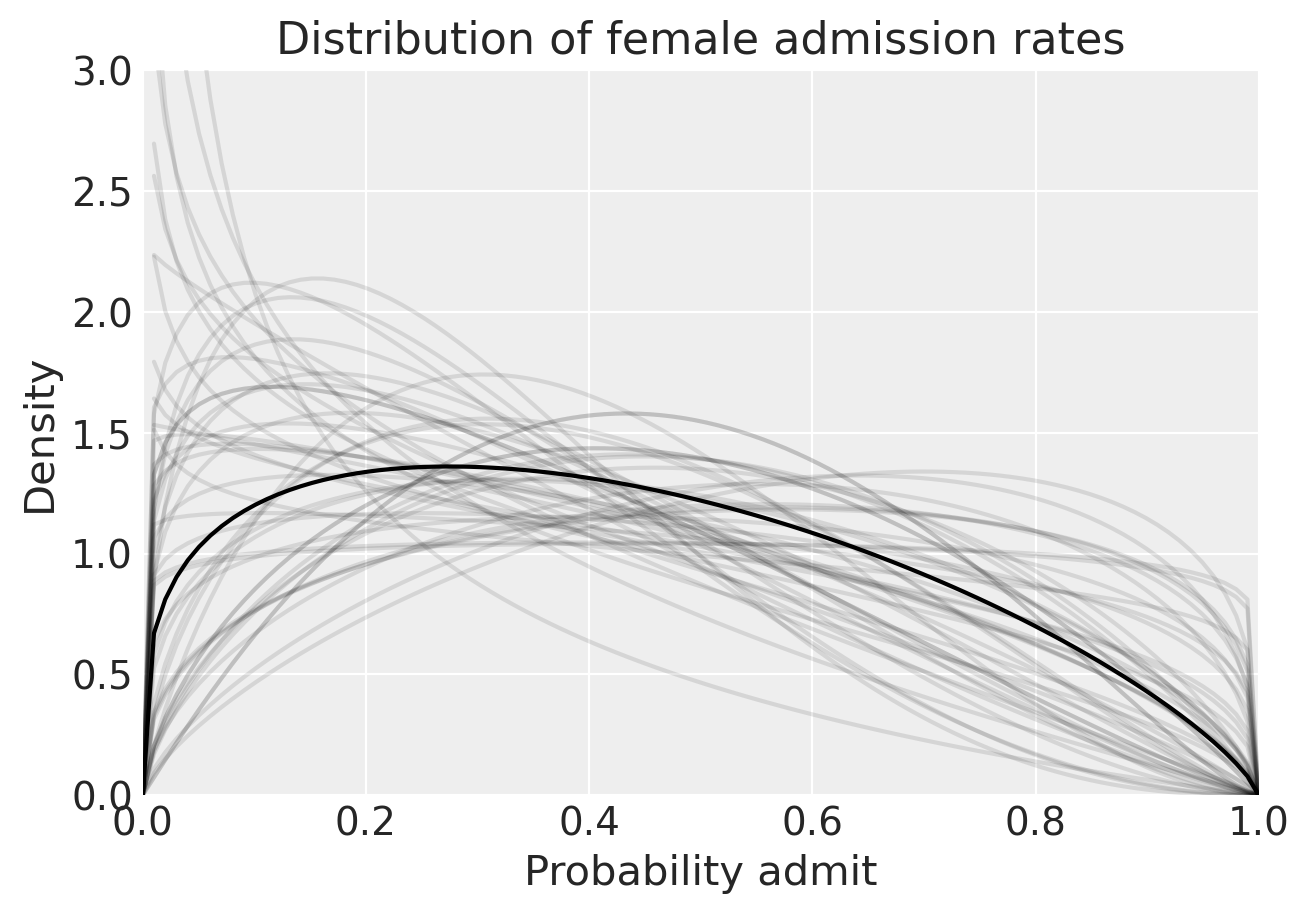

In [9]:
gid = 1
x_plot = np.linspace(0, 1, 100)

# draw posterior mean beta distribution:
pbar_mean = logistic(trace_12_1["a"][:, gid]).mean()
theta_mean = trace_12_1["theta"].mean()
plt.plot(
    x_plot,
    sp.stats.beta.pdf(x_plot, pbar_mean * theta_mean, (1.0 - pbar_mean) * theta_mean),
    c="k",
)

# draw 50 beta distributions sampled from posterior:
plt.plot(
    x_plot,
    sp.stats.beta.pdf(
        x_plot[:, np.newaxis],
        logistic(trace_12_1["a"][:, gid])[:50] * trace_12_1["theta"][:50],
        (1.0 - logistic(trace_12_1["a"][:, gid])[:50]) * trace_12_1["theta"][:50],
    ),
    c="k",
    alpha=0.1,
)

plt.xlim(0.0, 1.0)
plt.xlabel("Probability admit")
plt.ylim(0.0, 3.0)
plt.ylabel("Density")
plt.title("Distribution of female admission rates");

The result is shown above. Remember thart a posterior distribution simulaneously scores the plausability of every combination of parameter values. This plot shows 50 combinations of p and theta, smapled from the posterior. The thick curvve is the beta disrribution corresponding to the posterior mean. The central tendancy is for low probabilities of admission, less than 0.5. But the most plausible distributions allows for departments that admit most applicants. What the model has done is accomodate the variation among departments - there is a lot of variation!

100%|██████████| 2000/2000 [00:01<00:00, 1081.45it/s]


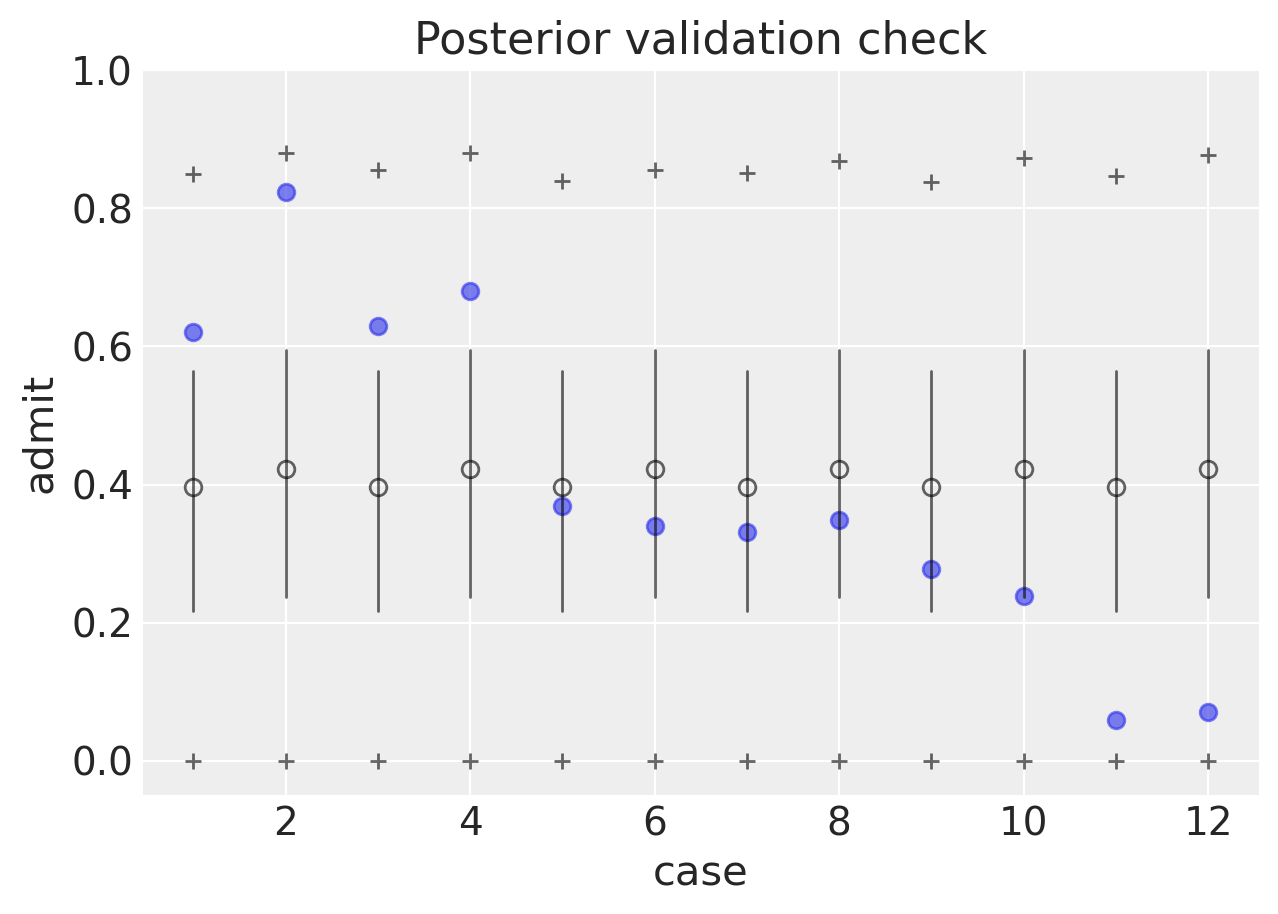

In [10]:
with m12_1:
    ppc = pm.sample_posterior_predictive(trace_12_1, random_seed=RANDOM_SEED)["A"]
pp_admit = ppc / N

plt.plot(range(1, 13), admit_df.admit / N, "C0o", ms=6, alpha=0.6)
plt.plot(range(1, 13), trace_12_1["pbar"].mean(0), "ko", fillstyle="none", ms=6, alpha=0.6)
plt.plot([range(1, 13), range(1, 13)], az.hpd(trace_12_1["pbar"]).T, "k-", lw=1, alpha=0.6)
plt.plot([range(1, 13), range(1, 13)], az.hpd(pp_admit).T, "k+", ms=6, alpha=0.6)

plt.xlabel("case")
plt.ylabel("admit")
plt.title("Posterior validation check")
plt.ylim(-0.05, 1);

The vertical axis shows the predicted proportion admitted, for each case on the horizontal. The model can't see the departments, because we didn't tell it about them. But it does see heterogeneity across rows, and it uses the eta distribution to estimate and anticipate that heterogenity

## Negative binomial (or gamma poisson)

A negative binomial, or more usefully called a gamma poisson, assumes that each poisson count observation has its own rate. It estimates the shape of a gamma distribution to describe the poisson rates across cases. Predictor variables adjust the shape of this distribution, not the expected value of each observation.

Lets see how this works with the oceanic tools example from the previous chapter. There was a highly influential point, Hawaii, that will become much less influential in the equivalent gamma-poisson model. Why? Because gamma-Poisson expects more variation around the mean rate. As a result, Hawaii ends up pulling the regression trend less.

dk = pd.read_csv("Kline.csv", sep=";")
P = standardize(np.log(dk.population)).values
P = P + np.abs(P.min()) + 0.1  # must be > 0 (see chp. 11)
c_id = (dk.contact == "high").astype(int).values

with pm.Model() as m12_2:
    a = pm.Normal("a", 1.0, 1.0, shape=2)
    b = pm.Exponential("b", 1.0, shape=2)
    g = pm.Exponential("g", 1.0)
    phi = pm.Exponential("phi", 1.0)

    cid = pm.intX(pm.Data("cid", c_id))
    P_ = pm.Data("P", P)
    lam = (tt.exp(a[cid]) * P_ ** b[cid]) / g # remember this was the scientific formula, hence the g

    T = pm.NegativeBinomial("total_tools", lam, phi, observed=dk.total_tools)

    trace_12_2 = pm.sample(2000, tune=2000, target_accept=0.9, random_seed=RANDOM_SEED)

# store pareto-k values for plot:
k_12 = az.loo(trace_12_2, pointwise=True).pareto_k.values

az.plot_trace(trace_12_2, compact=True);

## Zero Inflated Outcomes

Very often, the things we measure are not emissions from any pure process. Instead they are mixtures of multiple processes. Whenever there are different causes for the same observation, then a MIXTURE MODEL may be useful. A mixture model uses more than one simple probability distribution to model a mixture of causes. In effect, these models use more than one liklihood for the same outcome variable.

Count variables are especially prone to needing a mixture treatment. The reason is that a count of zero can often arise more than one way. A 'zero' means that nothing happened, and nothing can happen because the rate of events is low or rather because the process that generates events failed to get started.

So in this section you'll see how to construct simple zero-inflated models. You'll be able to use the same components from earlier models, but they'll be assembled in a different way. So if you ever need to use or interpret a zero inflated model, seeing how they are constructed should expand your modelling imagination

### Example: Zero inflated Poisson

Lets return to the example of monastery producing manuscripts. Each day, a large number of monks finish copying a small number of manuscripts. The process is essentially binomial, but with a large number of trials, and a very low probabilit the distribution tends towards a poisson.

Now imagine the monks take breaks on some days. On those days, no manuscripts are completed. Instead they get drunk. As the monastery owner, you'd like to know how often the monks drink. The obstacle for inference is that there will be zeros on honest non-drinking days, as well just by chance. So how can you estimate the number of days spent drinking.

So in a model a zero can arise for two reasons:

(1) the monks spent the day drinking 

(2) they worked that day but nevertheless failed to complete any manuscripts.

Let p be the probability the monks spend the day drinking. Let λ be the mean number of manuscripts completed, when the monks work

In [12]:
# define parameters
PROB_DRINK = 0.2  # 20% of days
RATE_WORK = 1.0  # average 1 manuscript per day

# sample one year of production
N = 365

# simulate days monks drink
drink = np.random.binomial(1, PROB_DRINK, size=N)

# simulate manuscripts completed
y = (1 - drink) * np.random.poisson(RATE_WORK, size=N)

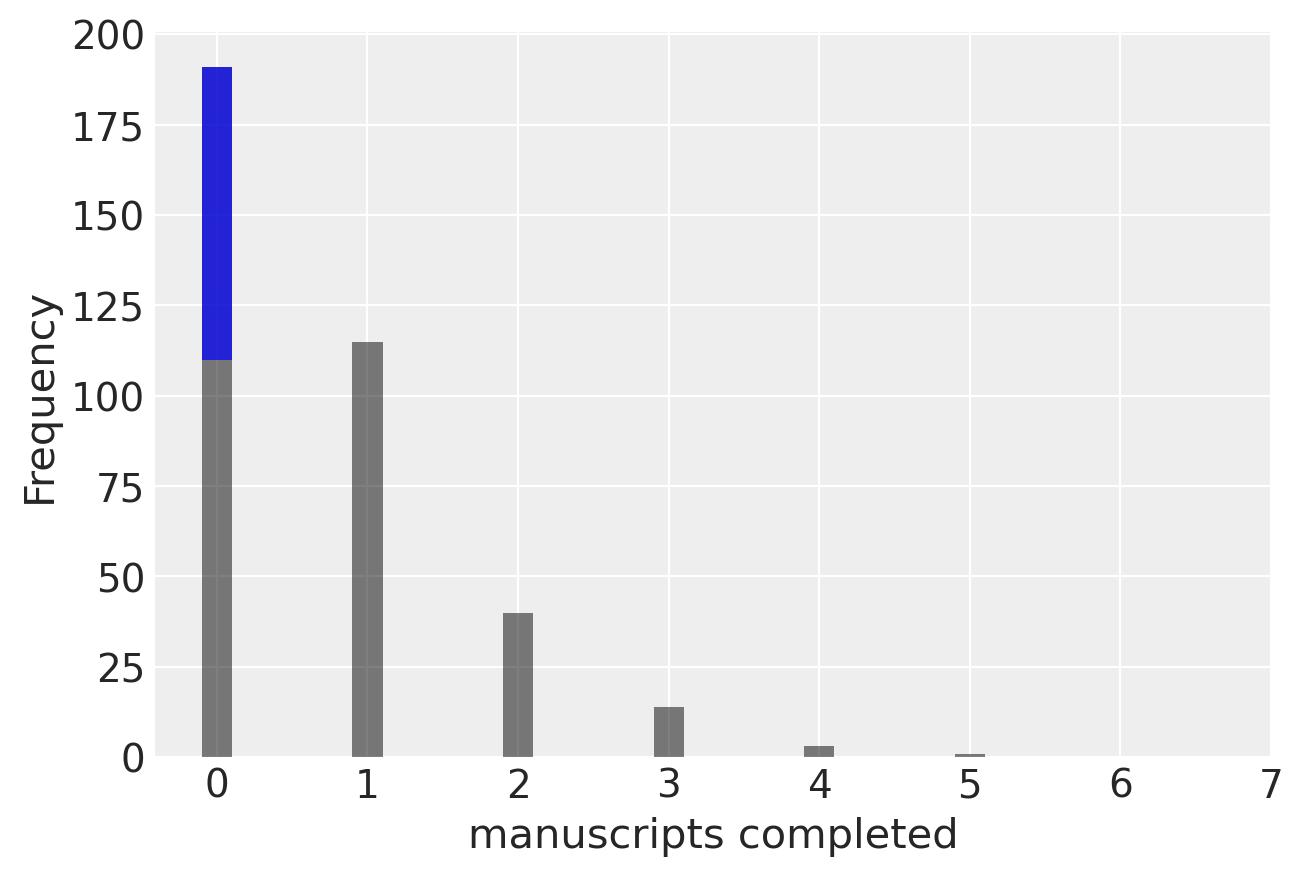

In [13]:
zeros_drink = drink.sum()
zeros_work = (y == 0).sum() - zeros_drink

bins = np.arange(y.max() + 1) - 0.5
plt.hist(y, bins=bins, align="mid", rwidth=0.2, color="k", alpha=0.5)
plt.bar(0.0, zeros_drink, bottom=zeros_work, width=0.2, color="b", alpha=0.7)

plt.xticks(bins + 0.5)
plt.xlabel("manuscripts completed")
plt.ylabel("Frequency");

In [14]:
with pm.Model() as m12_3:
    ap = pm.Normal("ap", -1.5, 1.0)
    al = pm.Normal("al", 1.0, 0.5)

    p = pm.math.invlogit(ap)
    lambda_ = pm.math.exp(al)

    y_obs = pm.ZeroInflatedPoisson("y_obs", 1.0 - p, lambda_, observed=y)

    trace_12_3 = pm.sample(tune=2000, random_seed=RANDOM_SEED)
az.summary(trace_12_3, round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [al, ap]
Sampling 4 chains, 0 divergences: 100%|██████████| 10000/10000 [00:05<00:00, 1774.19draws/s]


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
ap,-1.55,0.46,-2.35,-0.73,0.02,0.01,531.98,517.09,570.84,615.59,1.0
al,-0.11,0.09,-0.28,0.07,0.00,0.00,576.08,576.08,577.63,753.08,1.0


In [15]:
logistic(trace_12_3["ap"]).mean()  # probability drink

0.1841344206748558

In [16]:
np.exp(trace_12_3["al"]).mean()  # rate finish manuscripts, when not drinking

0.8960703856790596

Notice that we can get an accurate estimate of the proportion of the days the monks drnik, even though we can't say for any particular day whether or not they drank. 

This example is the simplest possible. In real problems, you might have predictor variables that are associated with one or both processes inside the zero-inflated Poisson mixture. In that case, you add those variables and their parameters to either or both linear models.

## Ordered categorical outcomes

It is very common in the social sciences, and occasional in the natural sciences, to have an outcome variable that is discrete, like a count, but in which the values merely indicate different ordered levels of some dimension. For example, if you were to ask how much you like to eat fish, on a scale of 1 to 7, you might say 5. If I were to ask 100 people the same question, I'd end up with 100 values between 1 and 7. In modelling each outcome variable I'd have to keep in mind that these values are ordered, because 7 is greater than 6. The result is a set of ORDERED CATEGORIES. Inlike a count, the differences are not necessarily equal. It might be much harder to mode someones preference for fish from 1 to 2 than it is to move it from 5 to 6. Just treating ordered categories as continuous measures is not a good idea.

Luckily there is a standard and accessible solution. In principle, an ordered categorical variable is just a multinomial prediction problem. But the constraint that the categories be ordered demands a special treatment. What we'd like is for any associated predictor variable, as it increases, to move predictions progressively through the categories in sequence. So for example if preference for ice-cream is positively associated with years of age, then the model should sequentially move predictions upwards as age increases. This presents a challenge, how to ensure that the linaer model maps onto the outcomes in the right order.